### fit tempo di attivazione al variare della memoria.
### parametri da fissare:n utenti, frazione di attivazione (30%??)
### acquisizione csv con i valori di attivazione e  memoria  (simulazioni a memoria fissa)
### valore medio ed errore del tempo di attivazione per ogni memoria
### fit con barre di errore 

In [1]:
library(data.table)

In [2]:
int <- read.csv(file="../../log/memoryLog2018_08_03_15_29_49.csv", nrows=11, sep=",")
maxtime   <- int$X..memorylog[2]
#maxtime
#int

In [15]:
DT1 <- fread("../../log/memoryLog2018_08_03_15_29_49.csv")
newsvec <- DT1[1:6,'news0']
newsvec <- as.vector(t(newsvec))
maxtime = DT1[][which.max(time)]$time
#maxtime
#newsvec
#DT
TB1 <- data.table(n1=integer(),n2=integer(), n3=integer(),n4=integer(),n5=integer(),n6=integer())
for (i in 1:maxtime) {
    nn1 =sum(apply(subset(DT1, time == i),1,function(x) length(which(x==newsvec[1]))))
    nn2 =sum(apply(subset(DT1, time == i),1,function(x) length(which(x==newsvec[2]))))
    nn3 =sum(apply(subset(DT1, time == i),1,function(x) length(which(x==newsvec[3]))))
    nn4 =sum(apply(subset(DT1, time == i),1,function(x) length(which(x==newsvec[4]))))
    nn5 =sum(apply(subset(DT1, time == i),1,function(x) length(which(x==newsvec[5]))))
    nn6 =sum(apply(subset(DT1, time == i),1,function(x) length(which(x==newsvec[6]))))
   
    TB1 <- rbindlist(list(TB1,  data.table(n1=nn1,n2=nn2,n3=nn3,n4=nn4,n5=nn5,n6=nn6)))
}

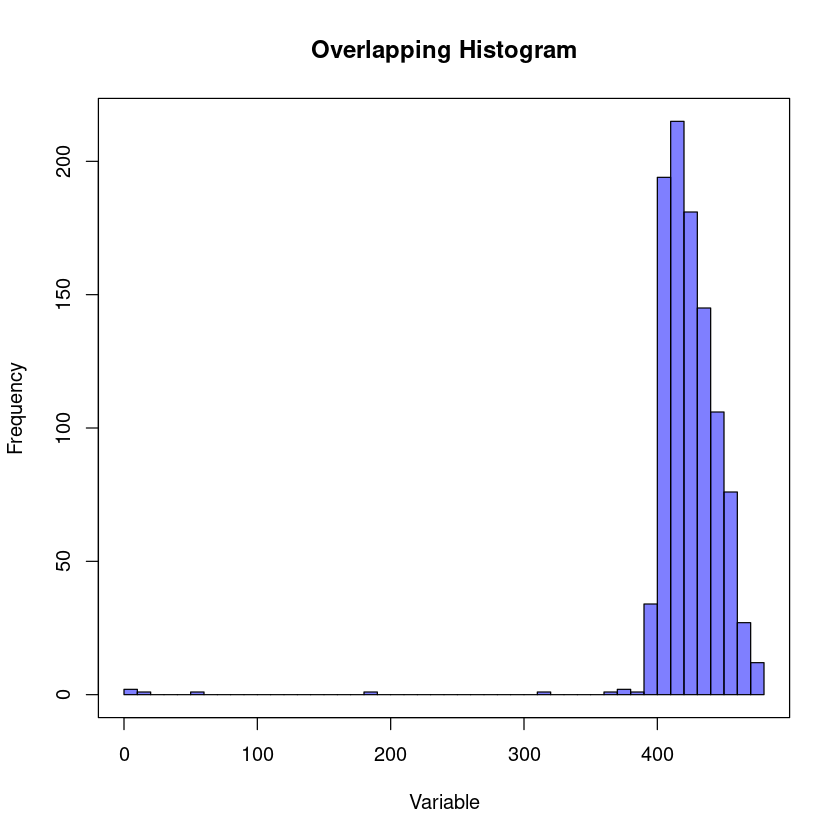

In [33]:
hist(TB1$n5, col=rgb(0,0,1,0.5),main="Overlapping Histogram", xlab="Variable", breaks=50)
#hist(TB1$n5, col=rgb(1,0,0,0.5), add=T, breaks=50)
#hist(TB1$n6, col=rgb(0,1,0,0.5), add=T, breaks=50)
box()

In [17]:
DT2 <- fread("../../log/memoryLog2018_08_03_15_30_44.csv")
newsvec <- DT2[1:6,'news0']
newsvec <- as.vector(t(newsvec))
maxtime = DT2[][which.max(time)]$time
#maxtime
#newsvec
#DT2
TB2 <- data.table(n1=integer(),n2=integer(), n3=integer(),n4=integer(),n5=integer(),n6=integer())
for (i in 1:maxtime) {
    nn1 =sum(apply(subset(DT2, time == i),1,function(x) length(which(x==newsvec[1]))))
    nn2 =sum(apply(subset(DT2, time == i),1,function(x) length(which(x==newsvec[2]))))
    nn3 =sum(apply(subset(DT2, time == i),1,function(x) length(which(x==newsvec[3]))))
    nn4 =sum(apply(subset(DT2, time == i),1,function(x) length(which(x==newsvec[4]))))
    nn5 =sum(apply(subset(DT2, time == i),1,function(x) length(which(x==newsvec[5]))))
    nn6 =sum(apply(subset(DT2, time == i),1,function(x) length(which(x==newsvec[6]))))
   
    TB2 <- rbindlist(list(TB2,  data.table(n1=nn1,n2=nn2,n3=nn3,n4=nn4,n5=nn5,n6=nn6)))
}

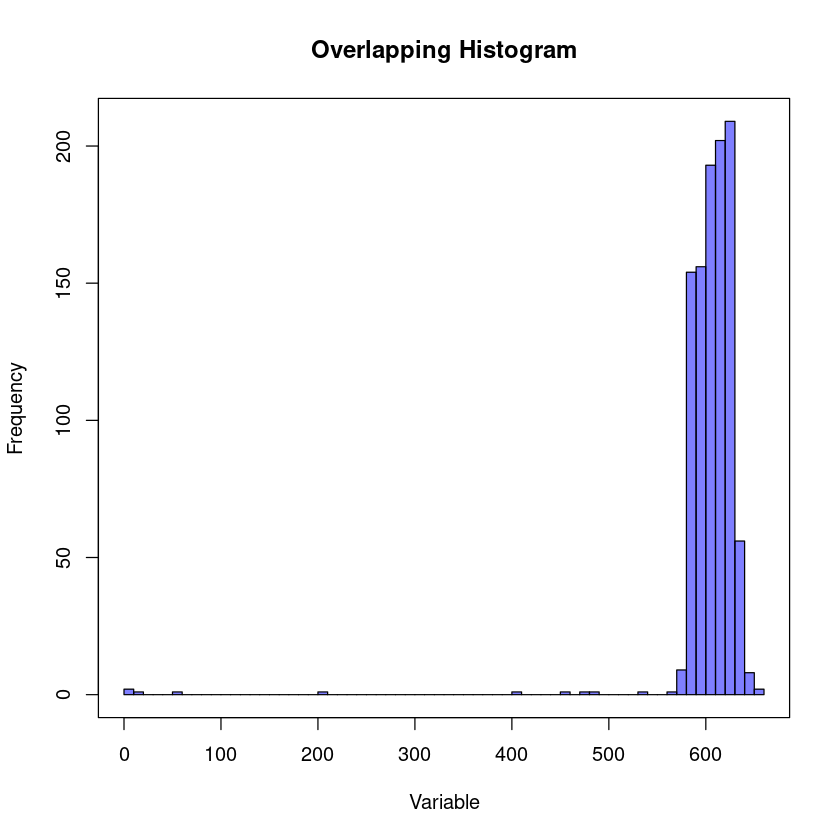

In [34]:
hist(TB2$n5, col=rgb(0,0,1,0.5),main="Overlapping Histogram", xlab="Variable", breaks=50)
#hist(TB2$n5, col=rgb(1,0,0,0.5), add=T, breaks=50)
#hist(TB2$n6, col=rgb(0,1,0,0.5), add=T, breaks=50)
box()

In [7]:
DT3 <- fread("../../log/memoryLog2018_08_03_15_31_04.csv")
newsvec <- DT3[1:6,'news0']
newsvec <- as.vector(t(newsvec))
maxtime = DT3[][which.max(time)]$time
#maxtime
#newsvec
#DT
TB3 <- data.table(n1=integer(),n2=integer(), n3=integer(),n4=integer(),n5=integer(),n6=integer())
for (i in 1:maxtime) {
    nn1 =sum(apply(subset(DT3, time == i),1,function(x) length(which(x==newsvec[1]))))
    nn2 =sum(apply(subset(DT3, time == i),1,function(x) length(which(x==newsvec[2]))))
    nn3 =sum(apply(subset(DT3, time == i),1,function(x) length(which(x==newsvec[3]))))
    nn4 =sum(apply(subset(DT3, time == i),1,function(x) length(which(x==newsvec[4]))))
    nn5 =sum(apply(subset(DT3, time == i),1,function(x) length(which(x==newsvec[5]))))
    nn6 =sum(apply(subset(DT3, time == i),1,function(x) length(which(x==newsvec[6]))))
   
    TB3 <- rbindlist(list(TB3,  data.table(n1=nn1,n2=nn2,n3=nn3,n4=nn4,n5=nn5,n6=nn6)))
}

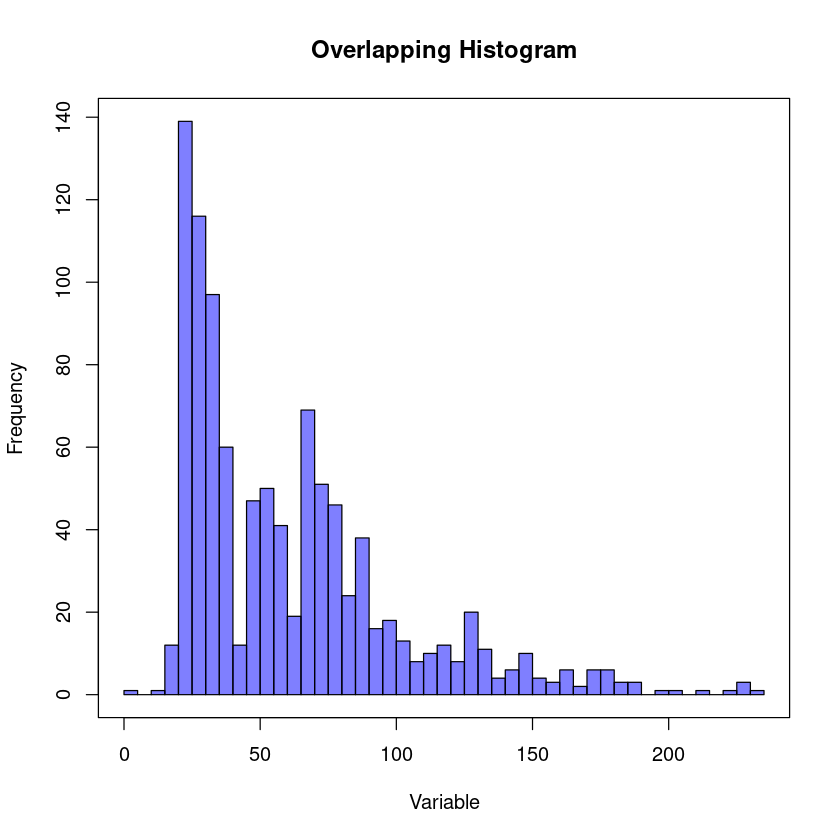

In [35]:
hist(TB3$n6, col=rgb(0,0,1,0.5),main="Overlapping Histogram", xlab="Variable", breaks=50)
#hist(TB3$n5, col=rgb(1,0,0,0.5), add=T, breaks=50)
#hist(TB3$n6, col=rgb(0,1,0,0.5), add=T, breaks=50)
box()

In [19]:
DT4 <- fread("../../log/memoryLog2018_08_03_15_31_22.csv")
newsvec <- DT4[1:6,'news0']
newsvec <- as.vector(t(newsvec))
maxtime = DT4[][which.max(time)]$time
#maxtime
#newsvec
#DT
TB4 <- data.table(n1=integer(),n2=integer(), n3=integer(),n4=integer(),n5=integer(),n6=integer())
for (i in 1:maxtime) {
    nn1 =sum(apply(subset(DT4, time == i),1,function(x) length(which(x==newsvec[1]))))
    nn2 =sum(apply(subset(DT4, time == i),1,function(x) length(which(x==newsvec[2]))))
    nn3 =sum(apply(subset(DT4, time == i),1,function(x) length(which(x==newsvec[3]))))
    nn4 =sum(apply(subset(DT4, time == i),1,function(x) length(which(x==newsvec[4]))))
    nn5 =sum(apply(subset(DT4, time == i),1,function(x) length(which(x==newsvec[5]))))
    nn6 =sum(apply(subset(DT4, time == i),1,function(x) length(which(x==newsvec[6]))))
   
    TB4 <- rbindlist(list(TB4,  data.table(n1=nn1,n2=nn2,n3=nn3,n4=nn4,n5=nn5,n6=nn6)))
}

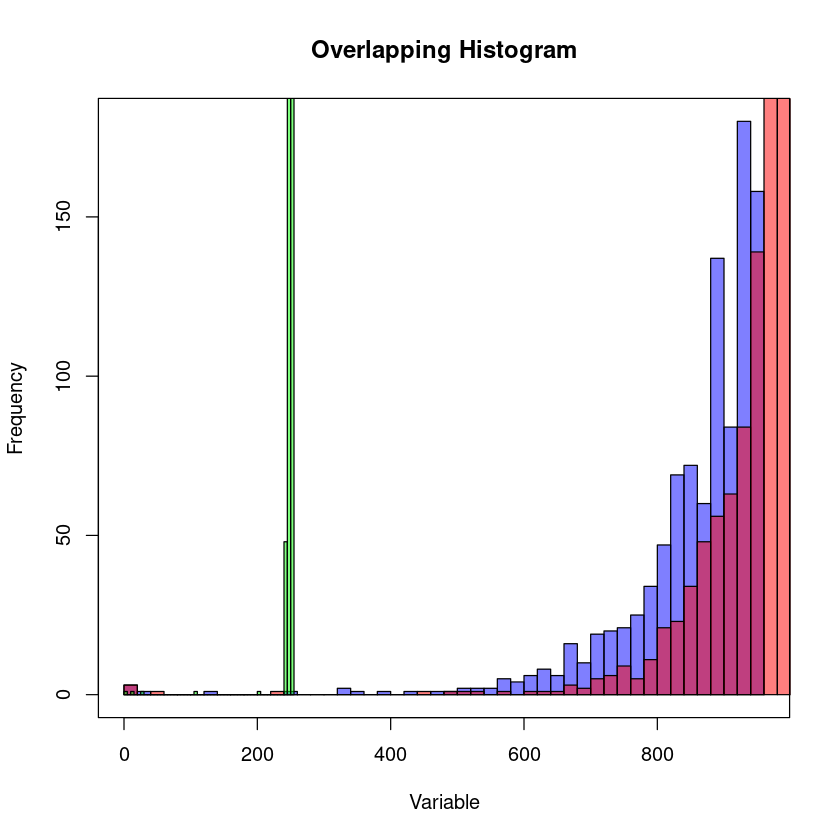

In [28]:
hist(TB4$n4, col=rgb(0,0,1,0.5),main="Overlapping Histogram", xlab="Variable", breaks=50)
hist(TB4$n5, col=rgb(1,0,0,0.5), add=T, breaks=50)
hist(TB4$n6, col=rgb(0,1,0,0.5), add=T, breaks=50)
box()

In [21]:
DT5 <- fread("../../log/memoryLog2018_08_03_15_31_53.csv")
newsvec <- DT5[1:6,'news0']
newsvec <- as.vector(t(newsvec))
maxtime = DT5[][which.max(time)]$time
#maxtime
#newsvec
#DT
TB5 <- data.table(n1=integer(),n2=integer(), n3=integer(),n4=integer(),n5=integer(),n6=integer())
for (i in 1:maxtime) {
    nn1 =sum(apply(subset(DT5, time == i),1,function(x) length(which(x==newsvec[1]))))
    nn2 =sum(apply(subset(DT5, time == i),1,function(x) length(which(x==newsvec[2]))))
    nn3 =sum(apply(subset(DT5, time == i),1,function(x) length(which(x==newsvec[3]))))
    nn4 =sum(apply(subset(DT5, time == i),1,function(x) length(which(x==newsvec[4]))))
    nn5 =sum(apply(subset(DT5, time == i),1,function(x) length(which(x==newsvec[5]))))
    nn6 =sum(apply(subset(DT5, time == i),1,function(x) length(which(x==newsvec[6]))))
   
    TB5 <- rbindlist(list(TB5,  data.table(n1=nn1,n2=nn2,n3=nn3,n4=nn4,n5=nn5,n6=nn6)))
}

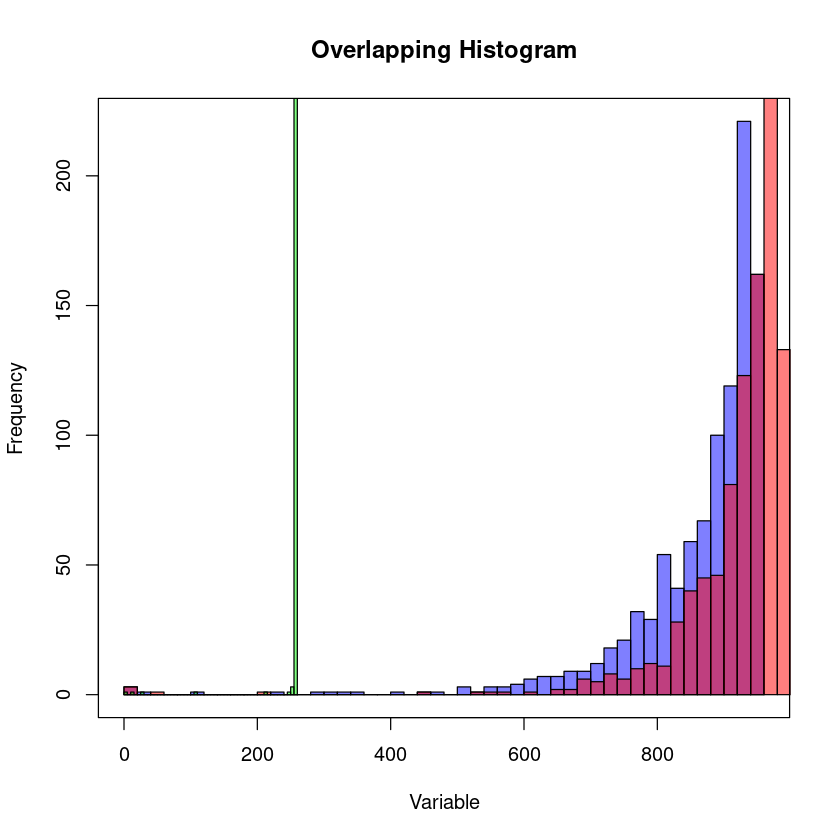

In [27]:
hist(TB5$n4, col=rgb(0,0,1,0.5),main="Overlapping Histogram", xlab="Variable", breaks=50)
hist(TB5$n5, col=rgb(1,0,0,0.5), add=T, breaks=50)
hist(TB5$n6, col=rgb(0,1,0,0.5), add=T, breaks=50)
box()

In [23]:
DT6 <- fread("../../log/memoryLog2018_08_03_15_32_09.csv")
newsvec <- DT6[1:6,'news0']
newsvec <- as.vector(t(newsvec))
maxtime = DT6[][which.max(time)]$time
#maxtime
#newsvec
#DT
TB6 <- data.table(n1=integer(),n2=integer(), n3=integer(),n4=integer(),n5=integer(),n6=integer())
for (i in 1:maxtime) {
    nn1 =sum(apply(subset(DT6, time == i),1,function(x) length(which(x==newsvec[1]))))
    nn2 =sum(apply(subset(DT6, time == i),1,function(x) length(which(x==newsvec[2]))))
    nn3 =sum(apply(subset(DT6, time == i),1,function(x) length(which(x==newsvec[3]))))
    nn4 =sum(apply(subset(DT6, time == i),1,function(x) length(which(x==newsvec[4]))))
    nn5 =sum(apply(subset(DT6, time == i),1,function(x) length(which(x==newsvec[5]))))
    nn6 =sum(apply(subset(DT6, time == i),1,function(x) length(which(x==newsvec[6]))))
   
    TB6 <- rbindlist(list(TB6,  data.table(n1=nn1,n2=nn2,n3=nn3,n4=nn4,n5=nn5,n6=nn6)))
}

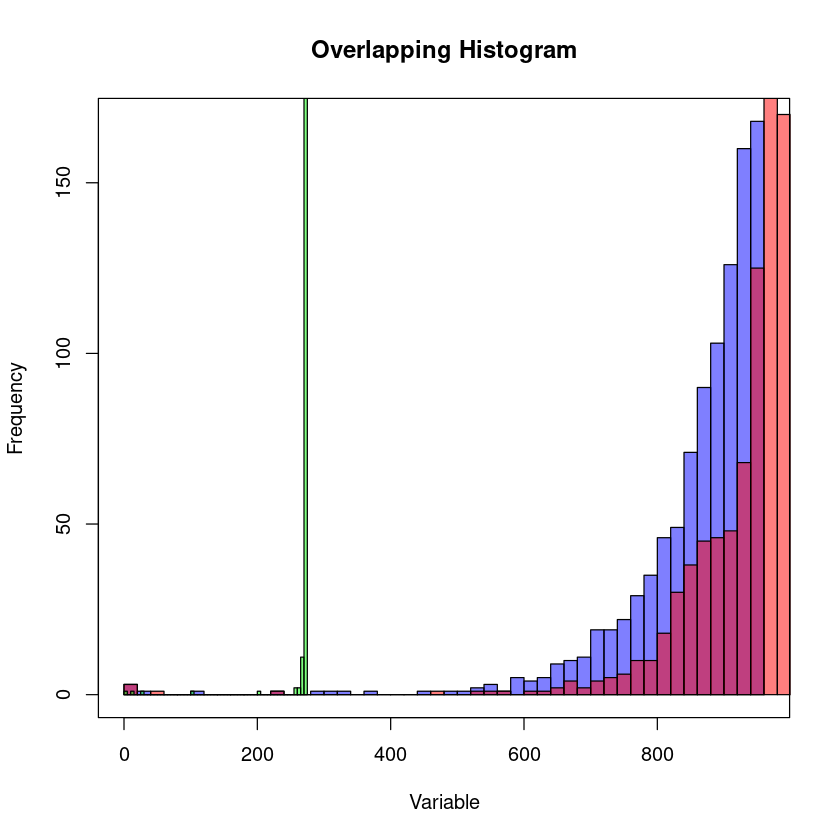

In [26]:
hist(TB6$n4, col=rgb(0,0,1,0.5),main="Overlapping Histogram", xlab="Variable", breaks=50)
hist(TB6$n5, col=rgb(1,0,0,0.5), add=T, breaks=50)
hist(TB6$n6, col=rgb(0,1,0,0.5), add=T, breaks=50)
box()